In [1]:
import csv
import pickle
import random

import glob2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn import metrics
from hyperopt import hp, Trials
from hyperopt import fmin, tpe, space_eval
import pandas as pd

from utils.misc.misc import shuffle_lists_by_group

/home/plerolland/Bureau/OHASISBIO_dataset/venv/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/training/scalograms20s"
FOLDS = 5
space = [hp.uniform('nb', 1, 10000), hp.loguniform('lr', np.log(0.01), np.log(1.0))]  # search space for SGBT parameters

In [3]:
with open(ROOT_DIR + "/dataset.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    lines = list(csv_reader)

pos_f = glob2.glob(f"{ROOT_DIR}/positives/*.npy")
pos_data = {p.split("/")[-1]:np.load(p) for p in pos_f}
neg_f = glob2.glob(f"{ROOT_DIR}/negatives/*.npy")
neg_data = {n.split("/")[-1]:np.load(n) for n in neg_f}

posX, negX = [], []
for line in lines:
    _X_list = posX if line[2]=="positive" else negX
    data = pos_data if line[2]=="positive" else neg_data
    station = line[0].split("/")[-1]
    idx = int(line[1])
    _X_list.append(data[station][idx])
posX, negX = np.array(posX), np.array(negX)
    
print(f"{len(posX)} positive samples and {len(negX)} negative samples found")
    
posY, negY = np.ones(len(posX)), np.zeros(len(negX))
shuffle_lists_by_group([(posX,posY),(negX,negY)], seed=0)

9229 positive samples and 24690 negative samples found


In [4]:
X_trains, Y_trains, X_valids, Y_valids = [], [], [], []
for i in range(FOLDS):
    start_valid_idx = int(len(posX) * i / FOLDS)
    end_valid_idx = int(len(posX) * (i + 1) / FOLDS)
    # unbalanced training set
    X_trains.append(np.concatenate((posX[:start_valid_idx], posX[end_valid_idx:],
                                    negX[:start_valid_idx], negX[end_valid_idx:])))
    Y_trains.append(np.concatenate((posY[:start_valid_idx], posY[end_valid_idx:],
                                    negY[:start_valid_idx], negY[end_valid_idx:])))
    # balanced validation set
    X_valids.append(np.concatenate((posX[start_valid_idx:end_valid_idx],
                                    negX[start_valid_idx:end_valid_idx])))
    Y_valids.append(np.concatenate((posY[start_valid_idx:end_valid_idx],
                                    negY[start_valid_idx:end_valid_idx])))
    shuffle_lists_by_group([(X_trains[-1], Y_trains[-1]), (X_valids[-1], Y_valids[-1])])
X_train_all = np.concatenate((posX, negX))
Y_train_all = np.concatenate((posY, negY))

In [5]:
def objective(args):
    nb, lr = args
    nb = int(nb)
    val_score = 0
    for i in range(FOLDS):
        classifier = HistGradientBoostingClassifier(learning_rate=lr, max_iter=nb, max_depth=4, random_state=0)
        res = classifier.fit(X_trains[i], Y_trains[i])
        pred = res.predict_proba(X_valids[i])[:,1]
        val_score += metrics.roc_auc_score(Y_valids[i], pred)
    return 1 - val_score / FOLDS

# minimize the objective over the space
trials = Trials()

best = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)

print(best)
print(space_eval(space, best))

 10%|█         | 1/10 [00:03<00:27,  3.07s/trial, best loss: 0.06547016088487323]



KeyboardInterrupt



In [12]:
print(objective((2421, 0.10524)))

0.935656455035217


In [24]:
with open("save_SGBT/save_trials_20s", 'wb') as f:
        pickle.dump(trials, f)

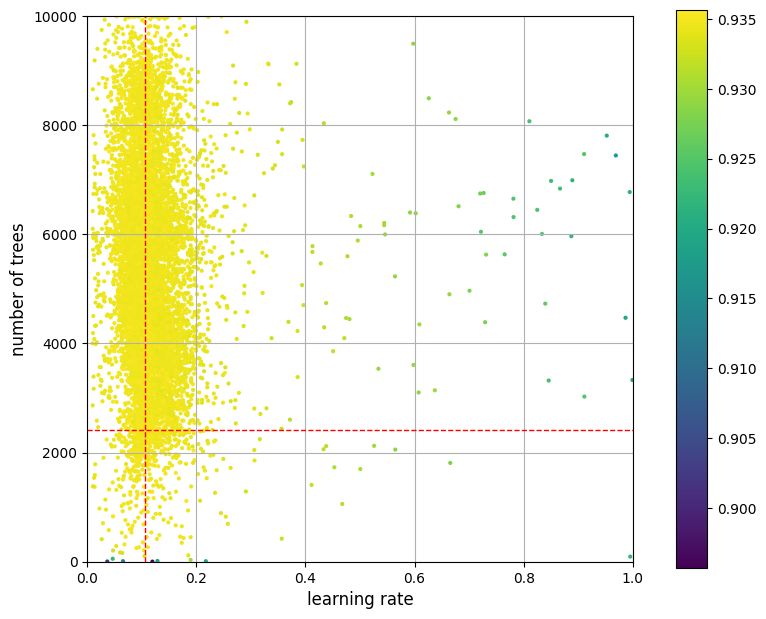

In [25]:
with open("save_SGBT/save_trials_20s", 'rb') as f:
        trials = pickle.load(f)
best = dict.copy(trials.best_trial["misc"]["vals"])
for i in best.keys():
    best[i] = best[i][0]
SEED = 0

lr_limits = (0, 1)
nb_limits = (0, 10_000)

xy_HO = [np.array([x['misc']['vals']['lr'] for x in trials.trials]), 
         np.array([x['misc']['vals']['nb'] for x in trials.trials]),
         np.array([x['result']['loss'] for x in trials.trials])]

best_HO = (-trials.best_trial['result']['loss'], (space_eval(space, best)[1], 
                                                space_eval(space, best)[0]))

# Defining mesh
xy_mesh = np.meshgrid(np.linspace(*lr_limits, 2001), np.linspace(*nb_limits, 2001))
fct = lambda x, y: np.zeros((len(x),len(y)))
fct_mesh = fct(xy_mesh[0], xy_mesh[1])

fig0 = plt.figure(figsize=(8, 8))

colors = 1 - xy_HO[2]
plot = plt.scatter(xy_HO[0][:,0], xy_HO[1][:,0], linewidth=0, marker='.', c=colors)

# Marking best result as a cross
plt.plot(lr_limits, [best_HO[1][1]]*2, linewidth=1, linestyle='--', color='red')
plt.plot([best_HO[1][0]]*2, nb_limits, linewidth=1, linestyle='--', color='red')

plt.gca().set_xlim(lr_limits)
plt.gca().set_ylim(nb_limits)
    
_ = fig0.colorbar(plot, ax=plt.gca(), fraction=0.05, pad=0.07, aspect=18)
plt.xlabel('learning rate', fontsize=12)
plt.ylabel('number of trees', fontsize=12)

plt.gca().grid(True)
plt.gca().set_aspect(lr_limits[1]/nb_limits[1])
plt.savefig('../../../figures/SGBT_parameters_space.png')

In [9]:
import datetime

classifier = HistGradientBoostingClassifier(learning_rate=0.10524, max_iter=2421, max_depth=4, random_state=0)
time = datetime.datetime.now()
for i in range(100):
    classifier.fit(X_train_all, Y_train_all)
print((datetime.datetime.now() - time) / 100)

with open("save_SGBT/save_model_20s", 'wb') as f:
    pickle.dump(classifier, f)

0:00:00.320815
